# The survival of the Gaussian distribution

In [134]:
import numpy as np 
import matplotlib.pyplot as plt
import corner
import sys 
import h5py
from scipy import stats
from scipy import optimize
sys.path.append("../code/")
from path_handler import PathHandler
import multiprocessing as mp
ph = PathHandler()

## Build the model

$$ f(x) = (1-\alpha) \mathcal{N}(x|\mu,\sigma) + \alpha G(x|\vec{\theta})$$

$\mathcal{N}$ is my gaussian distribution, and $G$ is going to be another skew distribution that I am going to test here to pick the best one. I will try the gamma distribution as well as a log normal. $\alpha$ is a weighting parameter that dictates how much each component weights towards the final signal 

In [141]:
def my_model_gamma(x, mu, sigma, shape, scale, loc, alpha):
    normal_part = (1 - alpha) * stats.norm.pdf(x, mu, sigma)
    gamma_part = alpha * stats.gamma.pdf(x, shape, scale=scale, loc=loc)
    return normal_part, gamma_part

def log_likelihood_gamma(params, data):
    mu, sigma, shape, scale, loc, alpha = params
    if mu < 0:
        print(mu)
    if sigma < 0:
        print(sigma )
    if shape < 0 :
        print(shape)
    if loc < 0:
        print(loc)
    if alpha < 0:
        print(alpha)
    
    normal_part, gamma_part = my_model_gamma(data, mu, sigma, shape, scale, loc, alpha)
    return -np.sum(np.log(normal_part + gamma_part))


def constrain_guess_gauss_gamma(data):
    numeric_threshold = 1e-10
    
    mu_init = np.mean(data)
    sigma_init = np.std(data)
    shape_init,scale_init,loc_init=stats.gamma.fit(data)
    alpha_init = 0.5

    if loc_init < 0:
        loc_init = np.abs(loc_init)

    if scale_init < 0:
        scale_init = np.abs(scale_init)
    
    if shape_init < 0:
        shape_init = np.abs(shape_init)
    
    mu_bounds,sigma_bounds                  = (numeric_threshold, np.inf), (0, np.inf)
    shape_bounds,scale_bounds,loc_bounds    = (numeric_threshold, np.inf), (numeric_threshold, np.inf), (numeric_threshold, np.inf)
    alpha_bounds                            = (0, 1)
    # put them together
    bounds = [mu_bounds, sigma_bounds, shape_bounds, scale_bounds, loc_bounds, alpha_bounds]
    initial_guess = [mu_init, sigma_init, shape_init, scale_init, loc_init, alpha_init]
    return initial_guess,bounds
    

In [142]:
def obtain_quantified(i,ratio):
    """
        Quantify the contribution of the hydrated and anhydrous components to the data.
    """
    try:
        basepath="/poubelle/sferrone/OREX/temp/EQ6_divided_by_EQ2_october_2024/"
        init_guess, bounds = constrain_guess_gauss_gamma(ratio)
        results = optimize.minimize(log_likelihood_gamma, init_guess, args=(ratio,), bounds=bounds, method='Nelder-Mead')
        mu, sigma, shape, scale, loc, alpha = results.x
        ANHYDROUS = alpha * stats.gamma.cdf(1, shape, scale=scale, loc=loc)
        HYDRATED = alpha * stats.gamma.sf(1, shape, scale=scale, loc=loc)
        tempdir = basepath + "myfit"+str(i)+".txt"
        myout=np.array([mu, sigma, shape, scale, loc, alpha, HYDRATED, ANHYDROUS])
        np.savetxt(tempdir, myout)
        return alpha, HYDRATED, ANHYDROUS
    except Exception as e:
        # Handle the exception (e.g., log the error and return a default value or re-raise the exception)
        print(f"Iteration {i}. An error occurred: {e} {i}")
        # Optionally, return default values or re-raise the exception
        return None, None, None

def model_switcher(survey_name):
    models={
        "EQ2":"one_gauss",
        "EQ6":"one_gauss"}
    return models[survey_name]
def open_EQ2_EQ6_band_depths():
    survey_name="EQ2"
    model_name=model_switcher(survey_name)
    inname = ph.band_depths_on_shape_model_fname(survey_name, model_name)
    with h5py.File(inname, 'r') as file:
        EQ2 = file['band_depths'][:,:]
    survey_name="EQ6"
    model_name=model_switcher(survey_name)
    inname = ph.band_depths_on_shape_model_fname(survey_name, model_name)
    with h5py.File(inname, 'r') as file:
        EQ6 = file['band_depths'][:,:]
    return EQ2,EQ6

## Hyper parameters

In [138]:
n_trials = 1000

Load in the global distribution of the EQ2 and EQ6

In [168]:
EQ2.shape[1]

1000

In [171]:
tasks = []
EQ2, EQ6 = open_EQ2_EQ6_band_depths()
for ii in range(EQ2.shape[1]):   
    ratio = EQ6[:,ii]/EQ2[:,ii]
    ratio = ratio[np.isfinite(ratio)]
    tasks.append((ii,ratio))


In [172]:
ncpu = mp.cpu_count()
with mp.Pool(ncpu) as pool:
    results = pool.starmap(obtain_quantified, tasks)

/data/sferrone/miniconda3/envs/pymc5/lib/python3.12/site-packages/scipy/optimize/_optimize.py:836: RuntimeWarning: invalid value encountered in subtract
  np.max(np.abs(fsim[0] - fsim[1:])) <= fatol):
/tmp/ipykernel_1936803/577541815.py:20: RuntimeWarning: divide by zero encountered in log
  return -np.sum(np.log(normal_part + gamma_part))
/tmp/ipykernel_1936803/577541815.py:20: RuntimeWarning: divide by zero encountered in log
  return -np.sum(np.log(normal_part + gamma_part))
/data/sferrone/miniconda3/envs/pymc5/lib/python3.12/site-packages/scipy/optimize/_optimize.py:836: RuntimeWarning: invalid value encountered in subtract
  np.max(np.abs(fsim[0] - fsim[1:])) <= fatol):
/data/sferrone/miniconda3/envs/pymc5/lib/python3.12/site-packages/scipy/optimize/_optimize.py:836: RuntimeWarning: invalid value encountered in subtract
  np.max(np.abs(fsim[0] - fsim[1:])) <= fatol):
/data/sferrone/miniconda3/envs/pymc5/lib/python3.12/site-packages/scipy/stats/_distn_infrastructure.py:1988: Runtim

In [207]:
basepath="/poubelle/sferrone/OREX/temp/EQ6_divided_by_EQ2_october_2024/"
fname = basepath + "myfit{:d}.txt".format(ii)
ii = 17
counts,bins,_=axis.hist(tasks[ii][1],bins=100,density=True);
nbins = int(np.ceil(np.sqrt(len(tasks[ii][1]))))
counts,bins=np.histogram(tasks[ii][1],nbins)
mu, sigma, shape, scale, loc, alpha, HYDRATED, ANHYDROUS=np.loadtxt(fname)
normal_part,gamma_part = my_model_gamma(bins, mu, sigma, shape, scale, loc, alpha)

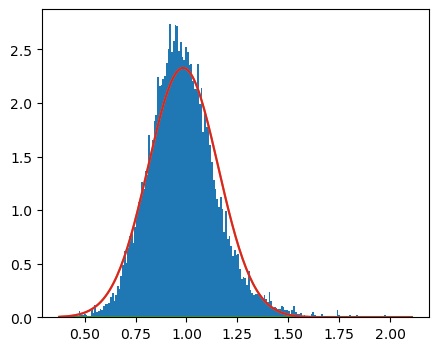

In [208]:
fig,axis=plt.subplots(1,1,figsize=(5,4))
axis.hist(tasks[ii][1],bins=nbins,density=True);
axis.plot(bins,normal_part,label="Gaussian")
axis.plot(bins,gamma_part,label="gamma part")
axis.plot(bins,normal_part+gamma_part,label="gamma part")

In [217]:
results
my_results = np.zeros((1000,3))
my_results[:,0] = np.array([1-x[0] for x in results])
my_results[:,1] = np.array([x[1] for x in results])
my_results[:,2] = np.array([x[2] for x in results])
# drop the rows where the fit failed which is when my_results[:,0] is 0


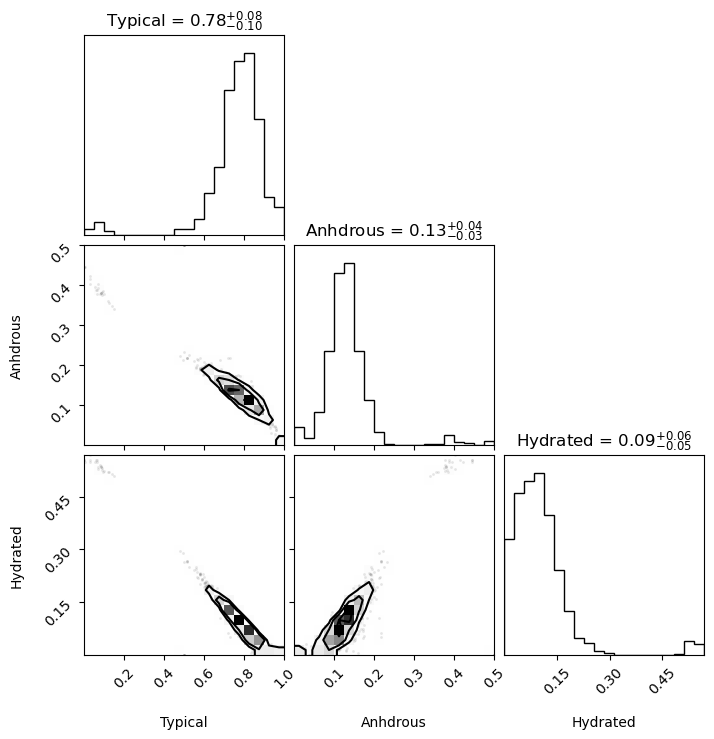

In [210]:
drop_critera=my_results[:,0]==1
my_results = my_results[~drop_critera]
corner.corner(my_results,labels=["Typical","Anhdrous","Hydrated"],show_titles=True);

In [218]:
foldername ="EQ6_divided_by_EQ2"
filename = "band_depth_ratio_survival_gauss_gamma_fits.hdf5"
outfname=ph.global_distributions(foldername,filename)

In [231]:
1-np.sum(fit_params[nparams-2:nparams])


array([0.16960766, 0.10229706, 0.0673106 ])

In [233]:

basepath="/poubelle/sferrone/OREX/temp/EQ6_divided_by_EQ2_october_2024/"
ii=0
fname = basepath + "myfit{:d}.txt".format(ii)
fit_params = np.loadtxt(fname)
nparams = len(fit_params)
surface_content_params = np.zeros((n_trials, 3))
model_params = np.zeros((n_trials, nparams-2))
for ii in range(n_trials):
    fname = basepath + "myfit{:d}.txt".format(ii)
    fit_parameters = np.loadtxt(fname)
    model_params[ii,:] = fit_parameters[0:(nparams-2)]
    surface_content_params[ii,:] = fit_parameters[(nparams-3):nparams]
surface_content_params[:,0] = 1 - surface_content_params[:,0] # change from survival to typical

model_parameter_names = ["mu", "sigma", "shape", "scale", "loc", "alpha"]
content_names = ["Typical", "Anhydrous", "Hydrated"]
attrs = {"n_trials":n_trials,
        "author":"Salvatore Ferrone",
        "date":"2024-oct-23",
        "email":"salvatore.ferrone@uniroma1.it",
        "Model": "Gaussian + Gamma",
}

In [235]:
myfile=h5py.File(outfname, 'w')
myfile.create_dataset("surface_content_parameters", data=surface_content_params)
myfile.create_dataset("surface_content_parameter_names", data=np.array(content_names, dtype='S'))
myfile.create_dataset("model_parameter", data=model_params)
myfile.create_dataset("model_parameter_names", data=np.array(model_parameter_names, dtype='S'))
myfile.attrs.update(attrs)
myfile.close()

In [237]:
myfile = h5py.File(outfname, 'r')